### 数据预处理

In [65]:
import math
import random
import pickle
import itertools

import numpy as np 
import pandas as pd 

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import label_ranking_average_precision_score, label_ranking_loss, coverage_error 
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import shuffle

from scipy.signal import resample

import matplotlib.pyplot as plt


np.random.seed(42)

import pickle


from keras.models import Model
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, Softmax, Add, Flatten, Activation# , Dropout
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

In [2]:
df = pd.read_csv("D:/cao/kaggle/ECG/mitbih_train.csv", header=None)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87554 entries, 0 to 87553
Columns: 188 entries, 0 to 187
dtypes: float64(188)
memory usage: 125.6 MB


In [3]:
df2 = pd.read_csv("D:/cao/kaggle/ECG/mitbih_test.csv", header=None)

In [4]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21892 entries, 0 to 21891
Columns: 188 entries, 0 to 187
dtypes: float64(188)
memory usage: 31.4 MB


In [5]:
# 训练集和测试集合并在一张表里

df = pd.concat([df, df2], axis=0)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109446 entries, 0 to 21891
Columns: 188 entries, 0 to 187
dtypes: float64(188)
memory usage: 157.8 MB


In [7]:
# 查看 5 个类的样本数

df[187].value_counts()

0.0    90589
4.0     8039
2.0     7236
1.0     2779
3.0      803
Name: 187, dtype: int64

In [8]:
M = df.values
X = M[:, :-1]
y = M[:, -1].astype(int)

In [9]:
X.shape

(109446, 187)

In [10]:
y.shape

(109446,)

In [11]:
# 删除不再使用的变量

del df
del df2
del M

### 数据展示

In [12]:
# 绘制 5 种不同类别的心电图

C0 = np.argwhere(y == 0).flatten()
C1 = np.argwhere(y == 1).flatten()
C2 = np.argwhere(y == 2).flatten()
C3 = np.argwhere(y == 3).flatten()
C4 = np.argwhere(y == 4).flatten()

在实验中，只使用 ECG 导联 II，MI 及健康的样本。且在实验中，重新的采样频率为 125 Hz。即为 0.008s。

一个信号包含 187 个值，大约有 1.5s。

In [13]:
import seaborn as sb
import scipy as sc
sb.set_style("whitegrid") # 显示网格

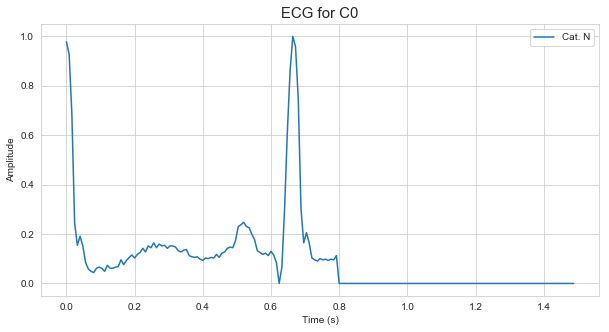

In [14]:
# 取每个类别的其中一组数据来展示

# 限定 x 的范围，即限定时间的范围
x = np.arange(0, 187)*0.008

plt.figure(figsize=(10,5))
plt.plot(x, X[C0, :][0], label='Cat. N')

plt.legend()
plt.title("ECG for C0", fontsize=15)
plt.ylabel("Amplitude", fontsize=10)
plt.xlabel("Time (s)", fontsize=10)
plt.show()

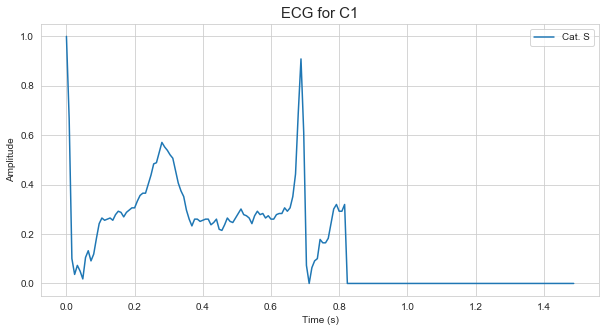

In [15]:
x = np.arange(0, 187)*0.008

plt.figure(figsize=(10,5))
plt.plot(x, X[C1, :][0], label='Cat. S')
plt.legend()
plt.title("ECG for C1", fontsize=15)
plt.ylabel("Amplitude", fontsize=10)
plt.xlabel("Time (s)", fontsize=10)
plt.show()

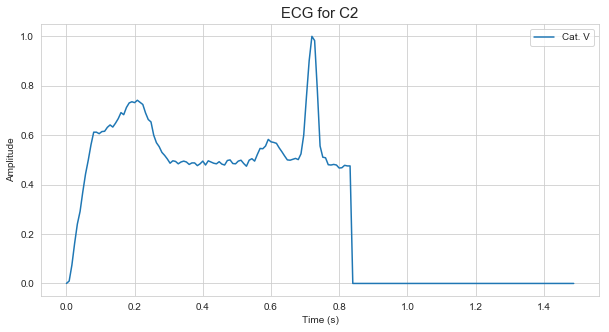

In [16]:
x = np.arange(0, 187)*0.008

plt.figure(figsize=(10,5))
plt.plot(x, X[C2, :][0], label='Cat. V')
plt.legend()
plt.title("ECG for C2", fontsize=15)
plt.ylabel("Amplitude", fontsize=10)
plt.xlabel("Time (s)", fontsize=10)
plt.show()

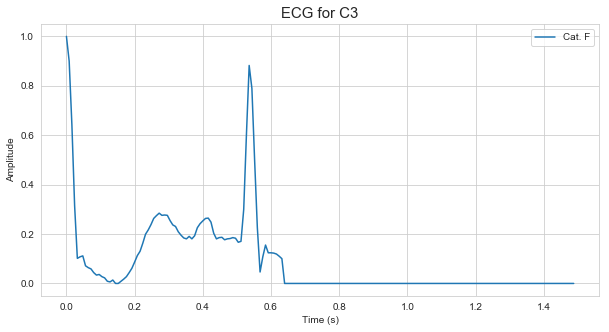

In [17]:
x = np.arange(0, 187)*0.008

plt.figure(figsize=(10,5))
plt.plot(x, X[C3, :][0], label='Cat. F')
plt.legend()
plt.title("ECG for C3", fontsize=15)
plt.ylabel("Amplitude", fontsize=10)
plt.xlabel("Time (s)", fontsize=10)
plt.show()

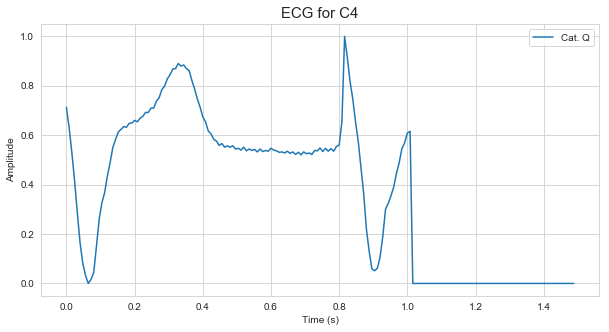

In [18]:
x = np.arange(0, 187)*0.008

plt.figure(figsize=(10,5))
#plt.plot(x, X[C0, :][0], label='Cat. N')
#plt.plot(x, X[C1, :][0], label='Cat. S')
#plt.plot(x, X[C2, :][0], label='Cat. V')
#plt.plot(x, X[C3, :][0], label='Cat. F')
plt.plot(x, X[C4, :][0], label='Cat. Q')
plt.legend()
plt.title("ECG for C4", fontsize=15)
plt.ylabel("Amplitude", fontsize=10)
plt.xlabel("Time (s)", fontsize=10)
plt.show()

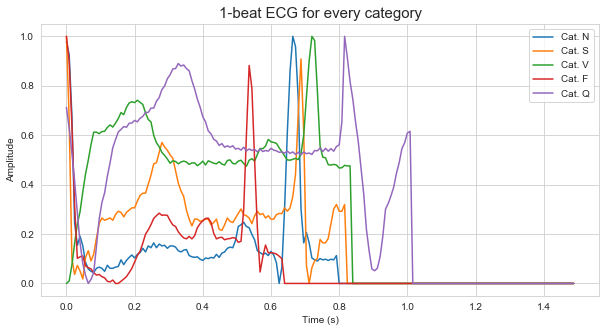

In [19]:
x = np.arange(0, 187)*0.008

plt.figure(figsize=(10,5))
plt.plot(x, X[C0, :][0], label='Cat. N')
plt.plot(x, X[C1, :][0], label='Cat. S')
plt.plot(x, X[C2, :][0], label='Cat. V')
plt.plot(x, X[C3, :][0], label='Cat. F')
plt.plot(x, X[C4, :][0], label='Cat. Q')
plt.legend()
plt.title("1-beat ECG for every category", fontsize=15)
plt.ylabel("Amplitude", fontsize=10)
plt.xlabel("Time (s)", fontsize=10)
plt.show()

### 数据增强

为了使所有类别的数据都处于相同的水平，所以需要进行数据增强处理。然而，这里只是将最少的类（第 3 类）增加到与类别 1 相同的级别。由此我们将能够具有大约 5x800 观测值的测试集。

In [20]:
# 伸展
def stretch(x):
    # 将 187 的长度随机重新采样
    l = int(187 * (1 + (random.random()-0.5)/3))
    y = resample(x, l)
    # 长度小于 187 的填充 0
    if l < 187:
        y_ = np.zeros(shape=(187,))
        y_[:l] = y
    # 长度大于 187 的裁剪到 187 的长度
    else:
        y_ = y[:187]
    return y_

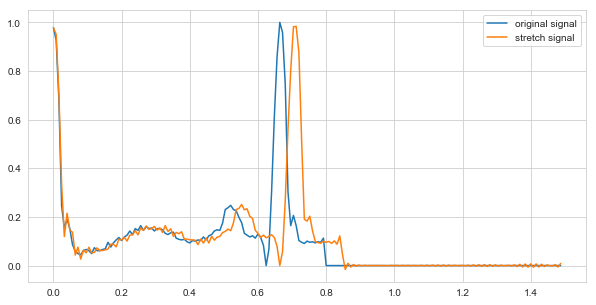

In [22]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1, 1, 1)
ax.plot(x, X[0, :], label='original signal') # X[0, :] == X[0]
ax.plot(x, stretch(X[0, :]), label='stretch signal')
plt.legend()

Amplifie le signal suivant la formule suivante :

new_x =  $-\alpha\cdot x^2 + -\alpha\cdot x^2 + x$ avec $-0.5﹤alpha﹤0.5$

In [23]:
# 放大
def amplify(x):
    alpha = (random.random()-0.5)
    factor = -alpha*x + (1+alpha) # 放大的幅度几乎很小
    return x*factor

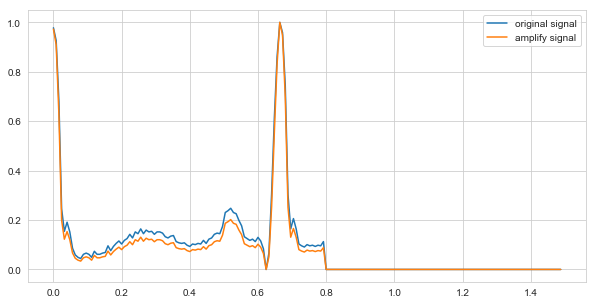

In [24]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1, 1, 1)
ax.plot(x, X[0, :], label='original signal') # X[0, :] == X[0]
ax.plot(x, amplify(X[0, :]), label='amplify signal')
plt.legend()

In [25]:
def augment(x):
    
    result = np.zeros(shape=(4, 187))
    for i in range(3):
        if random.random() < 0.33:
            new_y = stretch(x)
        elif random.random() < 0.66:
            new_y = amplify(x)
        else:
            new_y = stretch(x)
            new_y = amplify(new_y)
        result[i, :] = new_y
        
    return result

In [28]:
# 将 augment 这个函数按照所设定的 axis 应用
result = np.apply_along_axis(augment, axis=1, arr=X[C3]).reshape(-1, 187)

# 将 C3 的数据增强到与其他一样的级别
classes = np.ones(shape=(result.shape[0],),dtype=int)*3

# 按垂直方向堆叠扩增的数据
X = np.vstack([X, result]) 
y = np.hstack([y, classes])

### 划分数据集

In [29]:
# 随机从各个类别中抽取 800 个索引，用于后面建立测试集

subC0 = np.random.choice(C0, 800)
subC1 = np.random.choice(C1, 800)
subC2 = np.random.choice(C2, 800)
subC3 = np.random.choice(C3, 800)
subC4 = np.random.choice(C4, 800)

In [30]:
X_test = np.vstack([X[subC0], X[subC1], X[subC2], X[subC3], X[subC4]])
y_test = np.hstack([y[subC0], y[subC1], y[subC2], y[subC3], y[subC4]])
print("test set shape: ", X_test.shape)
print("test examples: ", X_test.shape[0])

test set shape:  (4000, 187)
test examples:  4000


In [31]:
# 除去测试集的数据，剩下的都是训练集

X_train = np.delete(X, [subC0, subC1, subC2, subC3, subC4], axis=0)
y_train = np.delete(y, [subC0, subC1, subC2, subC3, subC4], axis=0)
print("train examples: ", y_train.shape[0])

train examples:  112362


In [32]:
X_train, y_train = shuffle(X_train, y_train, random_state=0)
X_test, y_test = shuffle(X_test, y_test, random_state=0)

In [33]:
X_train = np.expand_dims(X_train, 2)
X_test = np.expand_dims(X_test, 2)

print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (112362, 187, 1)
y_train (112362,)
X_test (4000, 187, 1)
y_test (4000,)


In [34]:
# 转换为 one-hot 向量

ohe = OneHotEncoder()
y_train = ohe.fit_transform(y_train.reshape(-1, 1))
y_test = ohe.transform(y_test.reshape(-1, 1))

d:\anaconda3\envs\python36\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [35]:
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (112362, 187, 1)
y_train (112362, 5)
X_test (4000, 187, 1)
y_test (4000, 5)


### 模型结构

![论文提出的模型结构](https://ai2-s2-public.s3-us-west-2.amazonaws.com/figures/2017-08-08/0efe20fd1dc65030fa57f7c0727f13b93d51adce/1-Figure1-1.png)

In [36]:
n_obs, feature, depth = X_train.shape
batch_size = 512

In [37]:
K.clear_session()

def get_model():
    
    # Input
    inp = Input(shape=(feature, depth))
    # Conv
    C = Conv1D(filters=32, kernel_size=5, strides=1)(inp)

    # 【1】
    # Conv
    C11 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(C)
    # ReLU
    A11 = Activation("relu")(C11)
    # Conv
    C12 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A11)
    # Shortcut
    S11 = Add()([C12, C]) 
    # ReLU
    A12 = Activation("relu")(S11)
    # Pool
    M11 = MaxPooling1D(pool_size=5, strides=2)(A12)

    #【2】
    # Conv
    C21 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(M11)
    # ReLU
    A21 = Activation("relu")(C21)
    # Conv
    C22 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A21)
    # Shortcut
    S21 = Add()([C22, M11])
    # ReLU
    A22 = Activation("relu")(S11)
    # Pool
    M21 = MaxPooling1D(pool_size=5, strides=2)(A22)


    # 【3】
    # Conv
    C31 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(M21)
    # ReLU
    A31 = Activation("relu")(C31)
    # Conv
    C32 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A31)
    # Shortcut
    S31 = Add()([C32, M21])
    # ReLU
    A32 = Activation("relu")(S31)
    # Pool
    M31 = MaxPooling1D(pool_size=5, strides=2)(A32)

    # 【4】
    # Conv
    C41 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(M31)
    # ReLU
    A41 = Activation("relu")(C41)
    # Conv
    C42 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A41)
    # Shortcut
    S41 = Add()([C42, M31])
    # ReLU
    A42 = Activation("relu")(S41)
    # Pool
    M41 = MaxPooling1D(pool_size=5, strides=2)(A42)

    # 【5】
    # Conv
    C51 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(M41)
    # ReLU
    A51 = Activation("relu")(C51)
    # Conv
    C52 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A51)
    # Shortcut
    S51 = Add()([C52, M41])
    # ReLU
    A52 = Activation("relu")(S51)
    # Pool
    M51 = MaxPooling1D(pool_size=5, strides=2)(A52)

    F1 = Flatten()(M51)

    # FC
    D1 = Dense(32, name='dense_1')(F1)
    # ReLU
    A6 = Activation("relu")(D1)
    # FC
    D2 = Dense(32, name ='dense_2')(A6)
    D3 = Dense(5, name='dense_3_mitdb')(D2)
    # Softmax
    A7 = Softmax()(D3)

    model = Model(inputs=inp, outputs=A7)

    model.summary()
    
    return model

### 训练心律失常分类器

In [38]:
model = get_model()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 187, 1)       0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 183, 32)      192         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 183, 32)      5152        conv1d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 183, 32)      0           conv1d_2[0][0]                   
__________________________________________________________________________________________________
conv1d_3 (

In [39]:
def exp_decay(epoch):
    initial_lrate = 0.001
    k = 0.75
    t = n_obs//(10000 * batch_size)  # every epoch we do n_obs/batch_size iteration
    lrate = initial_lrate * math.exp(-k*t)
    return lrate

lrate = LearningRateScheduler(exp_decay)

In [40]:
adam = Adam(lr = 0.001, beta_1 = 0.9, beta_2 = 0.999)

In [41]:
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [42]:
from keras.callbacks import ModelCheckpoint

file_path = 'ECG_mitbd.h5'
checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [43]:
from livelossplot import PlotLossesKeras # for visualizing the loss and accuracy

history = model.fit(X_train, y_train, 
                    epochs=75, 
                    batch_size=batch_size, 
                    verbose=1, 
                    validation_data=(X_test, y_test), 
                    callbacks=[lrate]) # callbacks=[PlotLossesKeras()]

Train on 112362 samples, validate on 4000 samples
Epoch 1/75
112362/112362 [==============================] - 10s 92us/step - loss: 0.4097 - acc: 0.8712 - val_loss: 0.7340 - val_acc: 0.7765
Epoch 2/75
112362/112362 [==============================] - 6s 52us/step - loss: 0.1540 - acc: 0.9582 - val_loss: 0.5341 - val_acc: 0.8445
Epoch 3/75
112362/112362 [==============================] - 6s 54us/step - loss: 0.1122 - acc: 0.9688 - val_loss: 0.4454 - val_acc: 0.8635
Epoch 4/75
112362/112362 [==============================] - 6s 54us/step - loss: 0.0907 - acc: 0.9741 - val_loss: 0.3231 - val_acc: 0.8955
Epoch 5/75
112362/112362 [==============================] - 6s 52us/step - loss: 0.0775 - acc: 0.9773 - val_loss: 0.3957 - val_acc: 0.8872
Epoch 6/75
112362/112362 [==============================] - 6s 52us/step - loss: 0.0680 - acc: 0.9795 - val_loss: 0.2841 - val_acc: 0.9100
Epoch 7/75
112362/112362 [==============================] - 6s 53us/step - loss: 0.0618 - acc: 0.9812 - val_loss: 0

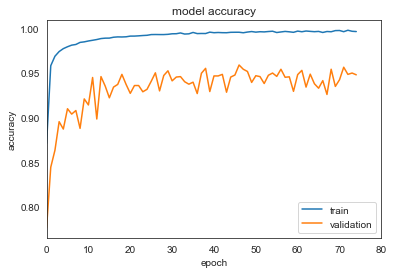

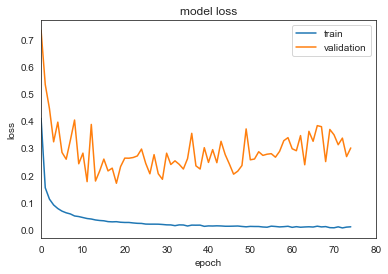

In [44]:
sb.set_style("white") # 不显示网格

# 绘制准确率
plt.plot(history.history['acc'])  
plt.plot(history.history['val_acc'])
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.xlim(0, 80)
plt.legend(['train', 'validation'], loc='lower right') 
plt.show()  

# 绘制 loss 
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.xlim(0, 80)
plt.legend(['train', 'validation'], loc='upper right')  
plt.show() 

In [45]:
y_pred = model.predict(X_test, batch_size=1000)

In [46]:
print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.83      1.00      0.91       800
           1       1.00      0.85      0.92       800
           2       0.96      0.95      0.96       800
           3       0.98      0.98      0.98       800
           4       1.00      0.96      0.98       800

   micro avg       0.95      0.95      0.95      4000
   macro avg       0.95      0.95      0.95      4000
weighted avg       0.95      0.95      0.95      4000



In [47]:
print("ranking-based average precision: {:.3f}".format(label_ranking_average_precision_score(y_test.todense(), y_pred)))
print("Rnaking loss: {:.3f}".format(label_ranking_loss(y_test.todense(), y_pred)))
print("Coverge_error: {:.3f}".format(coverage_error(y_test.todense(), y_pred)))

ranking-based average precision: 0.972
Rnaking loss: 0.016
Coverge_error: 1.064


Confusion matrix, without normalization


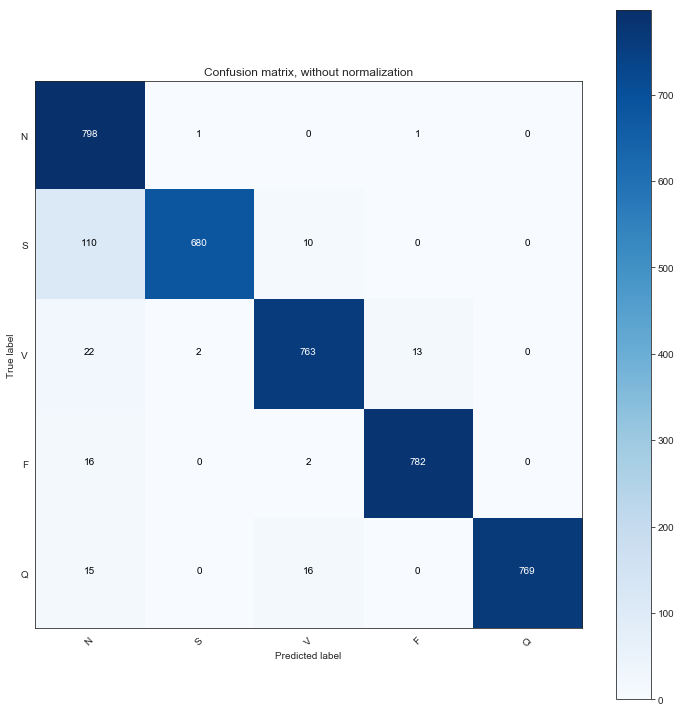

In [48]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting 'normalize=True'.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix, classes=['N', 'S', 'V', 'F', 'Q'],
                      title='Confusion matrix, without normalization')
plt.show()

### 训练 MI 预测器

In [49]:
ptb_nor = pd.read_csv('ptbdb_normal.csv', header=None)

In [50]:
ptb_nor.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4046 entries, 0 to 4045
Columns: 188 entries, 0 to 187
dtypes: float64(188)
memory usage: 5.8 MB


In [51]:
ptb_nor.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,1.000000,0.900324,0.358590,0.051459,0.046596,0.126823,0.133306,0.119125,0.110616,0.113047,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.000000,0.794681,0.375387,0.116883,0.000000,0.171923,0.283859,0.293754,0.325912,0.345083,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.909029,0.791482,0.423169,0.186712,0.000000,0.007836,0.063032,0.077002,0.074957,0.077342,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,0.478893,0.056760,0.064176,0.081289,0.072732,0.055619,0.048774,0.054478,0.041643,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.000000,0.867238,0.201360,0.099349,0.141336,0.120934,0.108516,0.096393,0.093436,0.100828,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [52]:
ptb_abnor = pd.read_csv('ptbdb_abnormal.csv', header=None)

In [53]:
ptb_abnor.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Columns: 188 entries, 0 to 187
dtypes: float64(188)
memory usage: 15.1 MB


In [54]:
ptb_abnor.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.932233,0.869679,0.886186,0.929626,0.908775,0.933970,0.801043,0.749783,0.687229,0.635100,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.000000,0.606941,0.384181,0.254237,0.223567,0.276836,0.253430,0.184826,0.153349,0.121872,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.000000,0.951613,0.923963,0.853303,0.791859,0.734255,0.672043,0.685100,0.670507,0.667435,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.977819,0.899261,0.230129,0.032348,0.142329,0.223660,0.328096,0.367837,0.381701,0.389094,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.935618,0.801661,0.805815,1.000000,0.722741,0.480789,0.454829,0.319834,0.266874,0.308411,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [55]:
df = pd.concat([ptb_nor, ptb_abnor], sort=True)

In [56]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.2, random_state=1337, stratify=df[187])


Y = np.array(df_train[187].values).astype(np.int8)
X = np.array(df_train[list(range(187))].values)[..., np.newaxis]

Y_test = np.array(df_test[187].values).astype(np.int8)
X_test = np.array(df_test[list(range(187))].values)[..., np.newaxis]

In [57]:
n_obs, feature, depth = X.shape
batch_size = 512

In [58]:
K.clear_session()

def MI_model():
    
    # Input
    inp = Input(shape=(feature, depth))
    # Conv
    C = Conv1D(filters=32, kernel_size=5, strides=1, trainable=False)(inp)

    # 【1】
    # Conv
    C11 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same', trainable=False)(C)
    # ReLU
    A11 = Activation("relu")(C11)
    # Conv
    C12 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same', trainable=False)(A11)
    # Shortcut
    S11 = Add()([C12, C]) 
    # ReLU
    A12 = Activation("relu")(S11)
    # Pool
    M11 = MaxPooling1D(pool_size=5, strides=2)(A12)

    #【2】
    # Conv
    C21 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same', trainable=False)(M11)
    # ReLU
    A21 = Activation("relu")(C21)
    # Conv
    C22 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same', trainable=False)(A21)
    # Shortcut
    S21 = Add()([C22, M11])
    # ReLU
    A22 = Activation("relu")(S11)
    # Pool
    M21 = MaxPooling1D(pool_size=5, strides=2)(A22)


    # 【3】
    # Conv
    C31 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same', trainable=False)(M21)
    # ReLU
    A31 = Activation("relu")(C31)
    # Conv
    C32 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same', trainable=False)(A31)
    # Shortcut
    S31 = Add()([C32, M21])
    # ReLU
    A32 = Activation("relu")(S31)
    # Pool
    M31 = MaxPooling1D(pool_size=5, strides=2)(A32)

    # 【4】
    # Conv
    C41 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same', trainable=False)(M31)
    # ReLU
    A41 = Activation("relu")(C41)
    # Conv
    C42 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same', trainable=False)(A41)
    # Shortcut
    S41 = Add()([C42, M31])
    # ReLU
    A42 = Activation("relu")(S41)
    # Pool
    M41 = MaxPooling1D(pool_size=5, strides=2)(A42)

    # 【5】
    # Conv
    C51 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same', trainable=False)(M41)
    # ReLU
    A51 = Activation("relu")(C51)
    # Conv
    C52 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same', trainable=False)(A51)
    # Shortcut
    S51 = Add()([C52, M41])
    # ReLU
    A52 = Activation("relu")(S51)
    # Pool
    M51 = MaxPooling1D(pool_size=5, strides=2)(A52)

    F1 = Flatten()(M51)

    # FC
    D1 = Dense(32, name='dense_1')(F1)
    # ReLU
    A6 = Activation("relu")(D1)
    # FC
    D2 = Dense(32, name='dense_2')(A6)
    D3 = Dense(1, activation='sigmoid', name='dense_3_ptbdb')(D2)

    model = Model(inputs=inp, outputs=D3)

    model.summary()
    
    return model

In [59]:
model = MI_model()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 187, 1)       0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 183, 32)      192         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 183, 32)      5152        conv1d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 183, 32)      0           conv1d_2[0][0]                   
__________________________________________________________________________________________________
conv1d_3 (

In [60]:
adam = Adam(lr = 0.001, beta_1 = 0.9, beta_2 = 0.999)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

In [66]:
file_path = 'ECG_ptbdb.h5'

checkout = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early = EarlyStopping(monitor="val_acc", mode="max", patience=5, verbose=1)
#redonplat = ReduceLROnPlateau(monitor="val_acc", mode="max", patience=3, verbose=2)

In [67]:
model.load_weights('ECG_mitdb.h5', by_name=True)

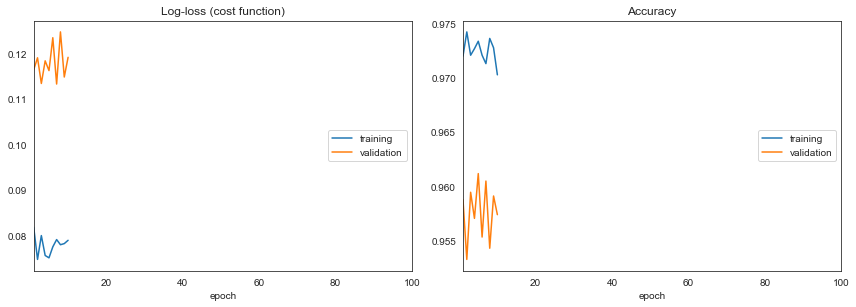

Log-loss (cost function):
training   (min:    0.075, max:    0.082, cur:    0.079)
validation (min:    0.113, max:    0.125, cur:    0.119)

Accuracy:
training   (min:    0.970, max:    0.974, cur:    0.970)
validation (min:    0.953, max:    0.961, cur:    0.957)
Epoch 00010: early stopping


In [94]:
from livelossplot import PlotLossesKeras # for visualizing the loss and accuracy

history = model.fit(X, Y, 
                    epochs=100, 
                    batch_size=batch_size, 
                    verbose=0, 
                    validation_data=(X_test, Y_test), 
                    callbacks=[checkout, PlotLossesKeras(), early]) # callbacks=[PlotLossesKeras()]

In [95]:
Y_pred = model.predict(X_test, batch_size=512).reshape(Y_test.shape[0],)
Y_pred = (Y_pred>0.5).astype(np.int8)

In [97]:
acc = accuracy_score(Y_test, Y_pred)

print("Test accuracy score : %s "% acc)

Test accuracy score : 0.9574029543112332 
